# Recurrent Neural Networks Models
In this notebook, we show an example of how RNNs can be used with darts.
If you are new to darts, we recommend you first follow the `darts-intro.ipynb` notebook.

In [1]:
# fix python path if working locally
from utils import fix_pythonpath_if_working_locally
fix_pythonpath_if_working_locally()

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import shutil
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm_notebook as tqdm

from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.dataprocessing.transformers import Scaler
from darts.models import RNNModel, ExponentialSmoothing
from darts.metrics import mape
from darts.utils.statistics import check_seasonality, plot_acf

import warnings
warnings.filterwarnings("ignore")
import logging
logging.disable(logging.CRITICAL)

## Air Passenger Example

In [5]:
# Read data:
df = pd.read_csv('AirPassengers.csv', delimiter=",")
series = TimeSeries.from_dataframe(df, 'Month', ['#Passengers'])

# Create training and validation sets:
train, val = series.split_after(pd.Timestamp('19590101'))

# Normalize the time series (note: we avoid fitting the transformer on the validation set)
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

Let's train an LSTM neural net. For using vanilla RNN or GRU instead, replace `'LSTM'` by `'RNN'` or `'GRU'`, respectively.

In [7]:
my_model = RNNModel(
    model='LSTM',
    input_chunk_length=12,
    output_chunk_length=1,
    hidden_size=25,
    n_rnn_layers=1,
    dropout=0.4,
    batch_size=16,
    n_epochs=400,
    optimizer_kwargs={'lr': 1e-3}, 
    model_name='Air_RNN',
    log_tensorboard=True,
    random_state=42
)

In [8]:
my_model.fit(train_transformed, val_series=val_transformed, verbose=True)  # 107

Training loss: 0.0019, validation loss: 0.0393


### Look at predictions on the validation set
Use the "current" model - i.e., the model at the end of the training procedure:

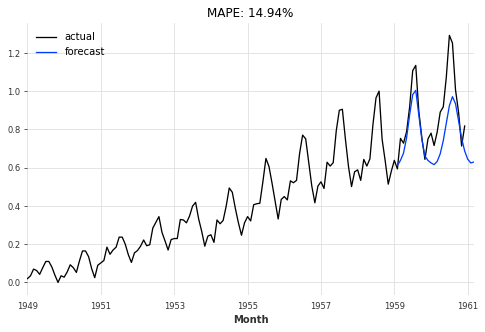

In [9]:
def eval_model(model):
    pred_series = model.predict(n=26)
    plt.figure(figsize=(8,5))
    series_transformed.plot(label='actual')
    pred_series.plot(label='forecast')
    plt.title('MAPE: {:.2f}%'.format(mape(pred_series, val_transformed)))
    plt.legend();
    
eval_model(my_model)

Use the best model obtained over training, according to validation loss:

loading model_best_190.pth.tar


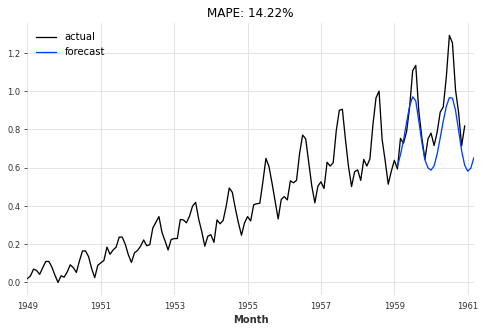

In [10]:
best_model = RNNModel.load_from_checkpoint(model_name='Air_RNN', best=True)
eval_model(best_model)

### Backtesting
Let's backtest our `RNN` model, to see how it performs at a forecast horizon of 6 months:

In [11]:
backtest_series = my_model.historical_forecasts(series_transformed,
                                                start=pd.Timestamp('19590101'),
                                                forecast_horizon=6,
                                                retrain=False,
                                                verbose=True)

MAPE: 11.31%


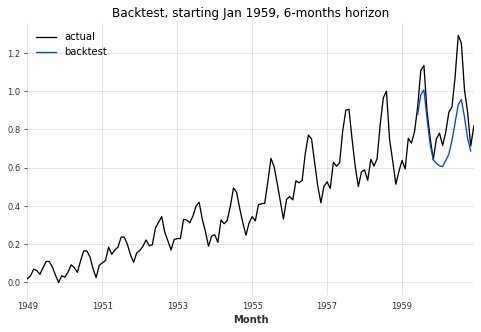

In [12]:
plt.figure(figsize=(8,5))
series_transformed.plot(label='actual')
backtest_series.plot(label='backtest')
plt.legend()
plt.title('Backtest, starting Jan 1959, 6-months horizon');
print('MAPE: {:.2f}%'.format(mape(transformer.inverse_transform(series_transformed), 
                                  transformer.inverse_transform(backtest_series))))

### Trials with a longer output length

In [13]:
my_model_gru = RNNModel(
    model='GRU',
    input_chunk_length=12,
    output_chunk_length=4,
    hidden_size=25,
    n_rnn_layers=1,
    batch_size=64,
    n_epochs=1500,
    dropout=0.2,
    model_name='Air_GRU_out12',
    log_tensorboard=True,
    random_state=42
)

In [14]:
my_model_gru.fit(train_transformed, val_series=val_transformed, verbose=True)

Training loss: 0.0041, validation loss: 0.0661


Result of training

Backtest with 6 month forecasting horizon

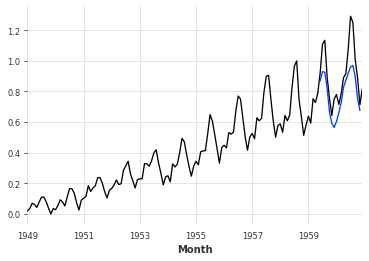

In [15]:
backtest_series = my_model_gru.historical_forecasts(series_transformed,
                                                    start=pd.Timestamp('19590101'),
                                                    forecast_horizon=6,
                                                    retrain=False,
                                                    verbose=True)
series_transformed.plot()
backtest_series.plot()

## Monthly sunspots
Let's now try a more challenging time series; that of the monthly number of sunspots since 1749. First, we build the time series from the data, and check its periodicity.

(True, 125)

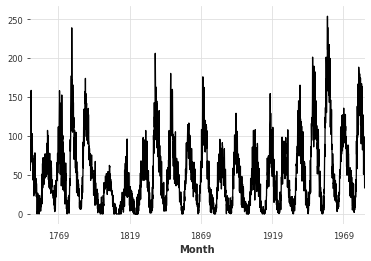

In [16]:
df2 = pd.read_csv('monthly-sunspots.csv', delimiter=",")
series_sunspot = TimeSeries.from_dataframe(df2, 'Month', ['Sunspots'])

series_sunspot.plot()
check_seasonality(series_sunspot, max_lag=240)

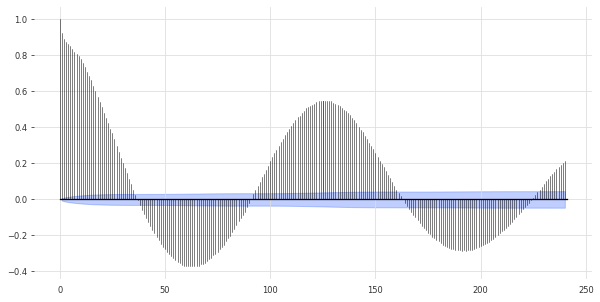

In [17]:
plot_acf(series_sunspot, 125, max_lag=240) # ~11 years seasonality

In [18]:
train_sp, val_sp = series_sunspot.split_after(pd.Timestamp('19401001'))

transformer_sunspot = Scaler()
train_sp_transformed = transformer_sunspot.fit_transform(train_sp)
val_sp_transformed = transformer_sunspot.transform(val_sp)
series_sp_transformed = transformer_sunspot.transform(series_sunspot)

In [19]:
my_model_sun = RNNModel(
    model='GRU',
    input_chunk_length=125,
    output_chunk_length=36,
    hidden_size=10,
    n_rnn_layers=1,
    batch_size=32,
    n_epochs=100,
    dropout=0.1,
    model_name='sun_GRU',
    nr_epochs_val_period=1,
    optimizer_kwargs={'lr': 1e-3},
    log_tensorboard=True,
    random_state=42
)

my_model_sun.fit(train_sp_transformed, val_series=val_sp_transformed, verbose=True)

Training loss: 0.0082, validation loss: 0.0223


To evaluate our model, we will simulate historic forecasting with a forecasting horizon of 3 years across the validation set. To speed things up, we will only look at every 10th forecast. For the sake of comparison, let's also fit an exponential smoothing model.

In [21]:
# Compute the backtest predictions with the two models
pred_series = my_model_sun.historical_forecasts(series_sp_transformed,
                                                start=pd.Timestamp('19401001'), 
                                                forecast_horizon=36,
                                                stride=10,
                                                retrain=False,
                                                last_points_only=True,
                                                verbose=True)
pred_series_ets = ExponentialSmoothing().historical_forecasts(series_sp_transformed,
                                                              start=pd.Timestamp('19401001'), 
                                                              forecast_horizon=36,
                                                              stride=10,
                                                              retrain=True,
                                                              last_points_only=True,
                                                              verbose=True)

RNN MAPE: 64.08876517962071
ETS MAPE: 593.7817328101518


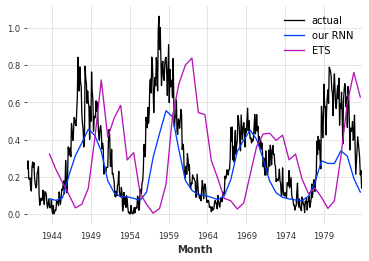

In [22]:
val_sp_transformed.plot(label='actual')
pred_series.plot(label='our RNN')
pred_series_ets.plot(label='ETS')
plt.legend();
print("RNN MAPE:", mape(pred_series, val_sp_transformed))
print("ETS MAPE:", mape(pred_series_ets, val_sp_transformed))